In [3]:
!pip install transformers

In [4]:
!pip install seqeval

In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import torch

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Naive Bayes
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# Stochastic Gradient Descent (SGD)
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

#BERT Model
from seqeval.metrics import f1_score, accuracy_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.utils import pad_sequences

import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [6]:
data = pd.read_csv("/kaggle/input/entity-annotated-corpus/ner_dataset.csv", encoding="latin1").fillna(method="ffill")
data

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
...,...,...,...,...
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O


**Train - Test split**

In [7]:
X = data.iloc[:,:3].values
y = data['Tag'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, X_test.shape, data.shape

((838860, 3), (209715, 3), (1048575, 4))

In [9]:
NER =np.unique(y) 

**Train - Validation split**

In [10]:
# Set seed for reproducibility
import random
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

X_train.shape,X_valid.shape

((671088, 3), (167772, 3))

In [12]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([['B-art', 258],
       ['B-eve', 202],
       ['B-geo', 24076],
       ['B-gpe', 10127],
       ['B-nat', 133],
       ['B-org', 12911],
       ['B-per', 10862],
       ['B-tim', 13017],
       ['I-art', 199],
       ['I-eve', 160],
       ['I-geo', 4691],
       ['I-gpe', 125],
       ['I-nat', 32],
       ['I-org', 10847],
       ['I-per', 11042],
       ['I-tim', 4247],
       ['O', 568159]], dtype=object)

In [13]:
# Example NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

# Convert NumPy arrays to lists of strings
X_train_list = [str(x) for x in X_train.tolist()]
X_test_list = [str(x) for x in X_test.tolist()]

# Create CountVectorizer and fit_transform
vectorizer = CountVectorizer()
X_train_cv = vectorizer.fit_transform(X_train_list)

# Apply transform on X_test
X_test_cv = vectorizer.transform(X_test_list)

**Naive Bayes:** TF-IDF transformation

In [14]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [15]:
nb_clf = MultinomialNB()

In [16]:
nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [17]:
nb_pred = nb_clf.predict(X_test_tf)

In [18]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=NER))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for Naive Bayes:
               precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        80
       B-eve       0.00      0.00      0.00        56
       B-geo       0.78      0.67      0.72      7549
       B-gpe       0.92      0.09      0.17      3211
       B-nat       0.00      0.00      0.00        35
       B-org       0.84      0.15      0.25      4004
       B-per       0.84      0.26      0.40      3412
       B-tim       0.94      0.54      0.69      4062
       I-art       0.00      0.00      0.00        48
       I-eve       0.00      0.00      0.00        53
       I-geo       0.97      0.02      0.04      1550
       I-gpe       0.00      0.00      0.00        42
       I-nat       0.00      0.00      0.00        11
       I-org       0.67      0.01      0.03      3225
       I-per       0.80      0.40      0.54      3448
       I-tim       0.00      0.00      0.00      1219
           O       0.90      1.00      0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Stochastic Gradient Descent (SGD):**

In [19]:
# Initialize the SGD Classifier
sgd_classifier = SGDClassifier(loss="log", alpha=0.0001, learning_rate="optimal", random_state=seed_value)

# Partial fit with training data
sgd_classifier.partial_fit(X_train_cv, y_train, classes=np.unique(y_train))

# Evaluation
y_pred = sgd_classifier.predict(X_test_cv)
print('Classification Report for Stochastic Gradient Descent (SGD):\n',classification_report(y_test, y_pred, target_names=NER))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for Stochastic Gradient Descent (SGD):
               precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        80
       B-eve       0.00      0.00      0.00        56
       B-geo       0.39      0.96      0.56      7549
       B-gpe       0.97      0.42      0.59      3211
       B-nat       0.00      0.00      0.00        35
       B-org       0.79      0.27      0.40      4004
       B-per       0.95      0.38      0.54      3412
       B-tim       0.94      0.56      0.71      4062
       I-art       0.00      0.00      0.00        48
       I-eve       0.00      0.00      0.00        53
       I-geo       0.93      0.24      0.39      1550
       I-gpe       0.00      0.00      0.00        42
       I-nat       0.00      0.00      0.00        11
       I-org       0.85      0.24      0.38      3225
       I-per       0.79      0.23      0.36      3448
       I-tim       0.00      0.00      0.00      1219
           O       

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**BERT Model:**

In [20]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [21]:
getter = SentenceGetter(data)

In [22]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [23]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [24]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
tag2idx

{'I-tim': 0,
 'B-per': 1,
 'B-geo': 2,
 'B-nat': 3,
 'I-org': 4,
 'B-art': 5,
 'I-eve': 6,
 'I-per': 7,
 'O': 8,
 'B-eve': 9,
 'I-gpe': 10,
 'B-org': 11,
 'I-nat': 12,
 'I-art': 13,
 'B-gpe': 14,
 'I-geo': 15,
 'B-tim': 16,
 'PAD': 17}

In [25]:
max_len = max(len(sentence) for sentence in sentences)
print("max sentence lentgh: ", max_len)

max sentence lentgh:  104


In [26]:
MAX_LEN = 104
bs = 32

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [28]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [30]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [31]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [32]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]


In [33]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
input_ids.shape

(47959, 104)

In [34]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
tags.shape

(47959, 104)

In [35]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

len(attention_masks)

47959

In [36]:
# Split the data into training, validation, and test sets
train_inputs, temp_inputs, train_tags, temp_tags = train_test_split(input_ids, tags,
                                                                    random_state=2018, test_size=0.2)
val_inputs, test_inputs, val_tags, test_tags = train_test_split(temp_inputs, temp_tags,
                                                                random_state=2018, test_size=0.2)
train_masks, temp_masks, _, _ = train_test_split(attention_masks, input_ids,
                                                 random_state=2018, test_size=0.2)
val_masks, test_masks, _, _ = train_test_split(temp_masks, temp_inputs,
                                               random_state=2018, test_size=0.2)

In [37]:
# Convert the data into PyTorch tensors
train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)
test_inputs = torch.tensor(test_inputs)

train_tags = torch.tensor(train_tags)
val_tags = torch.tensor(val_tags)
test_tags = torch.tensor(test_tags)

train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)
test_masks = torch.tensor(test_masks)

In [38]:
# Create DataLoader for training, validation, and test sets
train_data = TensorDataset(train_inputs, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

In [39]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions=False,
    output_hidden_states=False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

In [40]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [41]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [42]:
epochs = 3
max_grad_norm = 1.0

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [43]:
loss_values, validation_loss_values = [], []
accuracy_values, validation_accuracy_values = [], []

for epoch in trange(epochs, desc="Epoch"):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        loss.backward()

        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)

    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions, true_labels = [], []

    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)

    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                  for l_i in l if tag_values[l_i] != "PAD"]

    validation_accuracy = accuracy_score(pred_tags, valid_tags)
    validation_accuracy_values.append(validation_accuracy)

    accuracy_values.append(validation_accuracy)  # Store accuracy for plotting
        
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print()

    # Evaluation on the test set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions, true_labels = [], []

    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(test_dataloader)
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    test_tags = [tag_values[l_i] for l in true_labels
                 for l_i in l if tag_values[l_i] != "PAD"]
    test_accuracy = accuracy_score(pred_tags, test_tags)


    print("Test Accuracy: {}".format(test_accuracy))


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Accuracy: 0.9563044964066028



Epoch:  33%|███▎      | 1/3 [06:41<13:22, 401.21s/it]

Test Accuracy: 0.955030847117178
Validation Accuracy: 0.95988236025102



Epoch:  67%|██████▋   | 2/3 [13:21<06:40, 400.46s/it]

Test Accuracy: 0.9584537498206563
Validation Accuracy: 0.9609489882567364



Epoch: 100%|██████████| 3/3 [20:01<00:00, 400.36s/it]

Test Accuracy: 0.9602164422308307


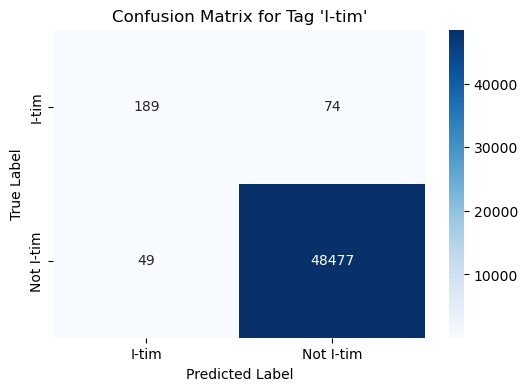

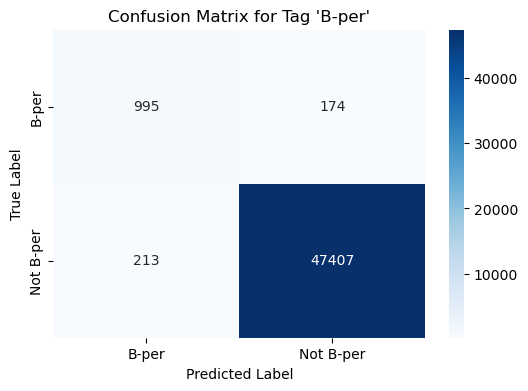

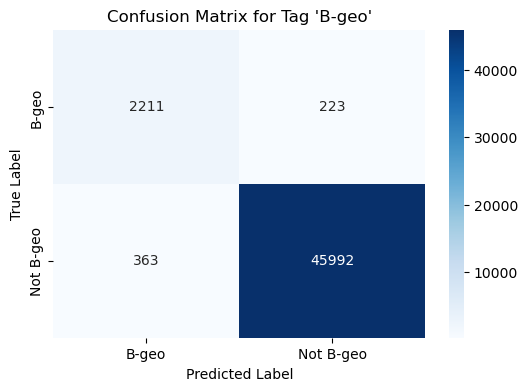

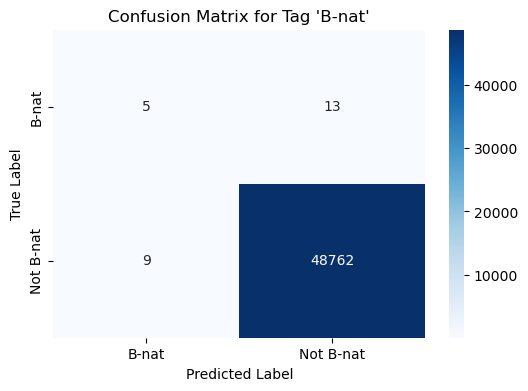

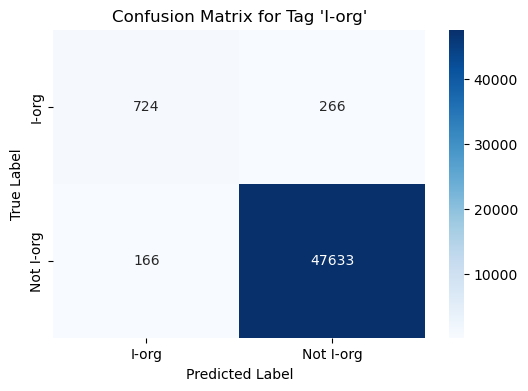

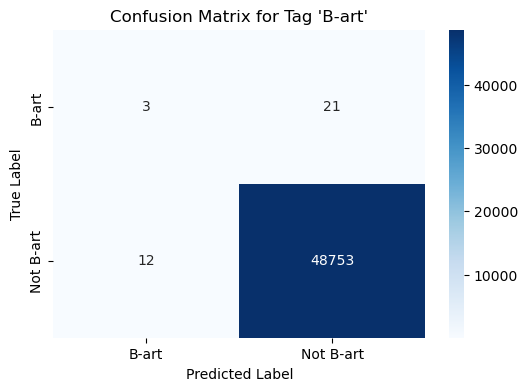

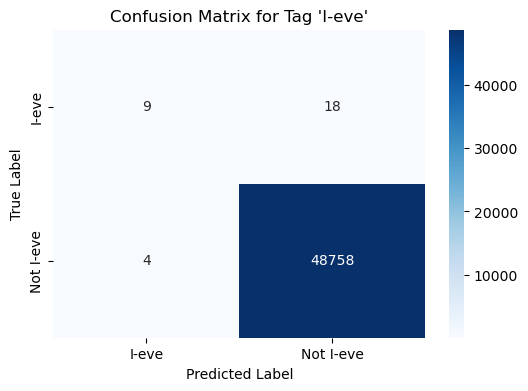

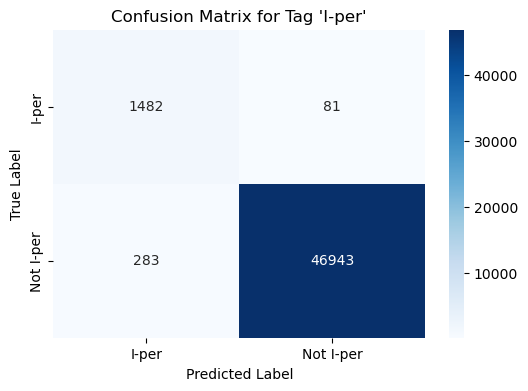

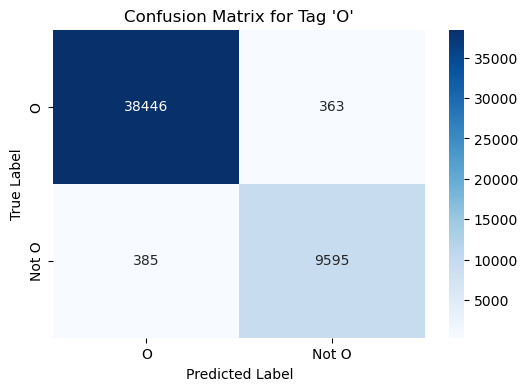

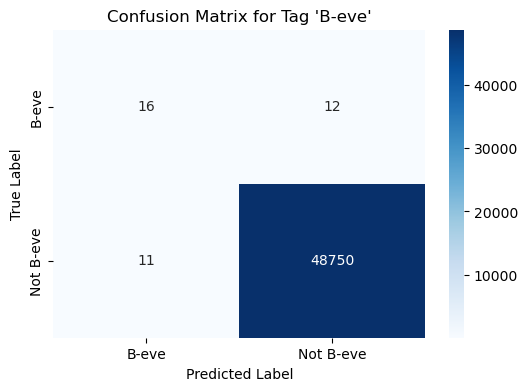

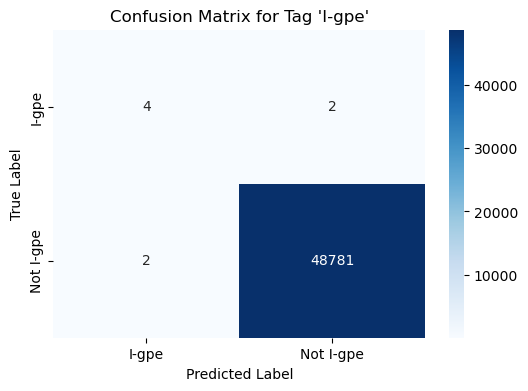

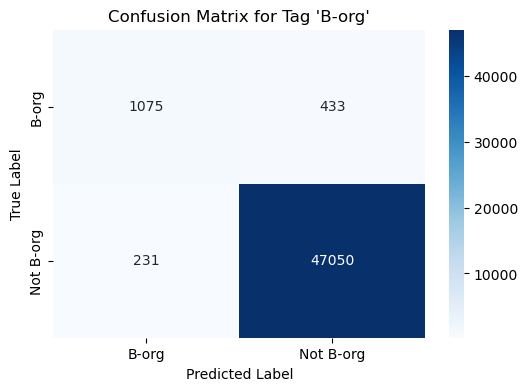

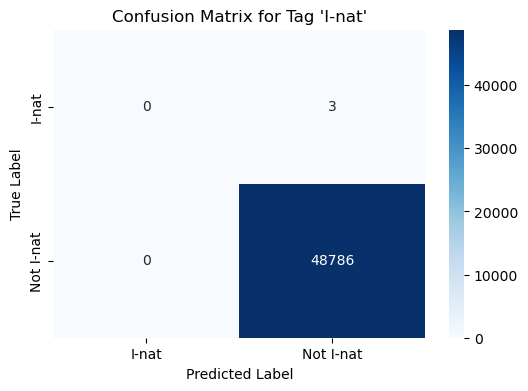

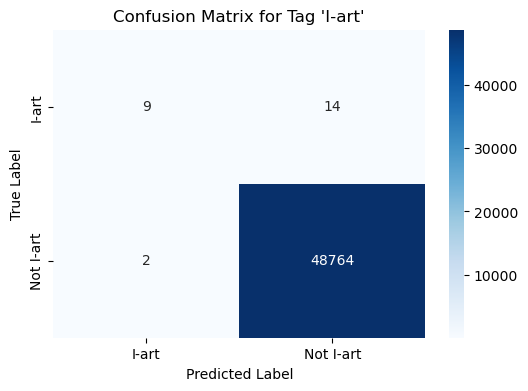

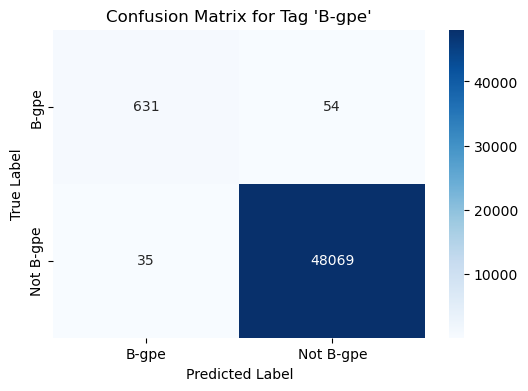

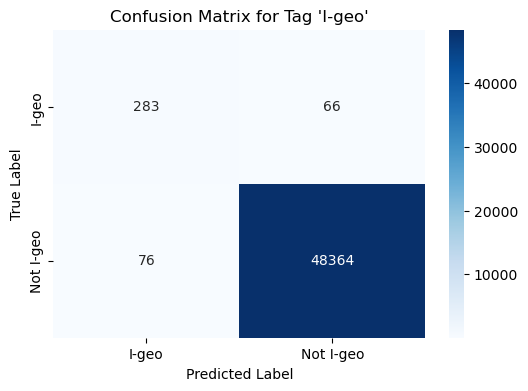

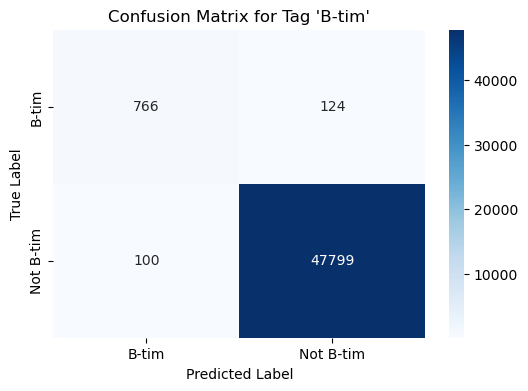

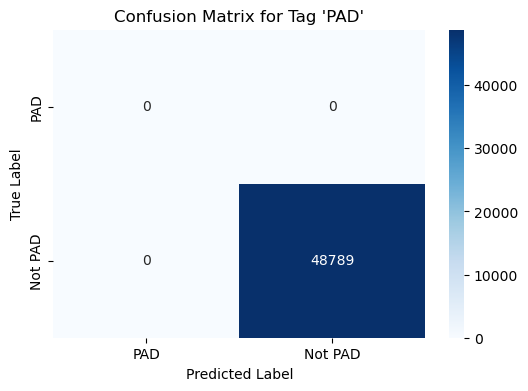

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create an empty dictionary to store the confusion matrices for each tag value
confusion_matrices = {}

# Iterate over each tag value
for tag_value in tag_values:
    # Filter the predicted and true tags for the current tag value
    filtered_pred_tags = [tag_value if tag == tag_value else "Not " + tag_value for tag in pred_tags]
    filtered_true_tags = [tag_value if tag == tag_value else "Not " + tag_value for tag in test_tags]

    # Calculate the confusion matrix for the current tag value
    cm = confusion_matrix(filtered_true_tags, filtered_pred_tags, labels=[tag_value, "Not " + tag_value])

    # Store the confusion matrix in the dictionary
    confusion_matrices[tag_value] = cm

# Plot the confusion matrices for each tag value
for tag_value, cm in confusion_matrices.items():
    # Create a color-coded heatmap using seaborn
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True, xticklabels=[tag_value, "Not " + tag_value], yticklabels=[tag_value, "Not " + tag_value])
    plt.title(f"Confusion Matrix for Tag '{tag_value}'")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


In [45]:
classification_rep = classification_report(test_tags, pred_tags)
print("Classification Report BERT Model:\n", classification_rep)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report BERT Model:
               precision    recall  f1-score   support

       B-art       0.20      0.12      0.15        24
       B-eve       0.59      0.57      0.58        28
       B-geo       0.86      0.91      0.88      2434
       B-gpe       0.95      0.92      0.93       685
       B-nat       0.36      0.28      0.31        18
       B-org       0.82      0.71      0.76      1508
       B-per       0.82      0.85      0.84      1169
       B-tim       0.88      0.86      0.87       890
       I-art       0.82      0.39      0.53        23
       I-eve       0.69      0.33      0.45        27
       I-geo       0.79      0.81      0.80       349
       I-gpe       0.67      0.67      0.67         6
       I-nat       0.00      0.00      0.00         3
       I-org       0.81      0.73      0.77       990
       I-per       0.84      0.95      0.89      1563
       I-tim       0.79      0.72      0.75       263
           O       0.99      0.99      0.99   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


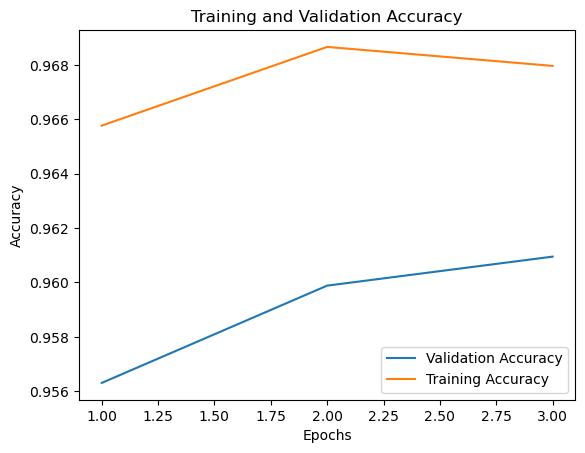

In [46]:
# Plotting the training and validation accuracy
epochs_list = range(1, epochs + 1)
plt.plot(epochs_list, accuracy_values, label='Validation Accuracy')
plt.plot(epochs_list, [1 - val_loss for val_loss in validation_loss_values], label='Training Accuracy')  # Plotting training accuracy (1 - validation loss)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

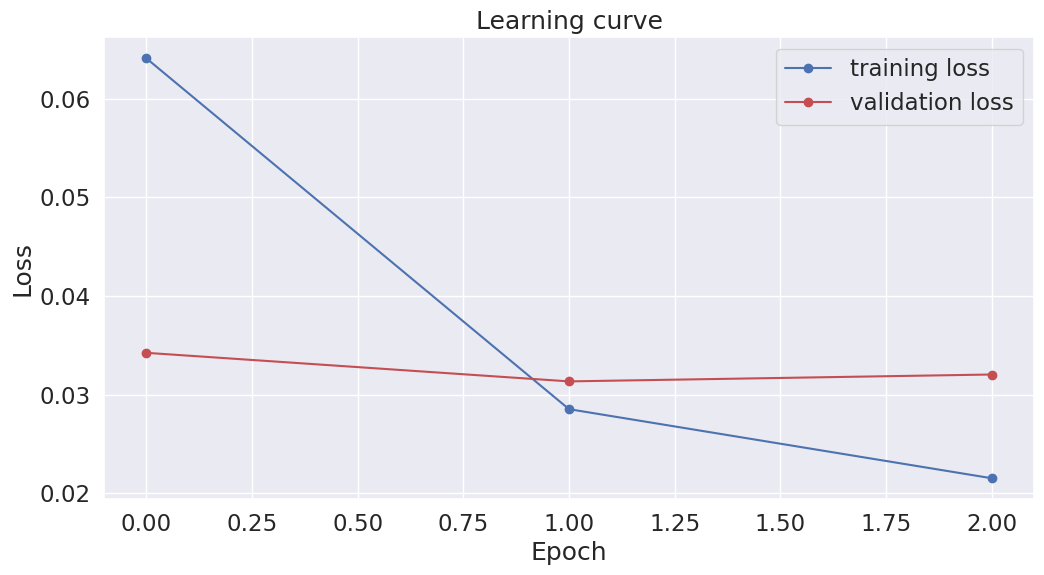

In [47]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [48]:
test_sentence = """
Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a 
reporter for the network, about protests in Minnesota and elsewhere. 
"""


In [49]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()


In [50]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [51]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)


In [52]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


O	[CLS]
B-per	Mr
B-per	.
I-per	Trump
O	’
O	s
O	tweets
O	began
O	just
O	moments
O	after
O	a
B-org	Fox
I-org	News
O	report
O	by
B-per	Mike
I-per	Tobin
O	,
O	a
O	reporter
O	for
O	the
O	network
O	,
O	about
O	protests
O	in
B-geo	Minnesota
O	and
O	elsewhere
O	.
O	[SEP]
